# 6 Clustering: Elbow and silhouette methods for finding number of clusters to run k-Means 
#### Dataset1+Dataset2 (Arabidopsis Col-0 + Arabidopsis infected)

Cynthia Soto <br>
Fecha: 6 de Octubre 2020 <br>
Datatype representation: normalized values in log2 scale (genome name reference) <br>
Data quantify with HTSeq (alignments done with STAR SA)  <br>

**Details of the algorithm is a fundamental step in the process of writing your k-means clustering pipeline in Python. What I show here will help you decide if k-means is the right choice to solve your clustering problem.**

**Data Assumptions:** <br>
Datasets are transformed to log2 scale. <br>
Damage samples are removed from the matrix <br>
Gene IDs in ceros across samples are removed from the matrix <br>
Distributions are known. <br>

<br>
**Composition of the matrix:** <br>
18 RNASeq samples (8 control + 10 infected)<br>
Matrix size to perform this clustering is 88% (features:genes) respecting the original one (due ceros removed).<br>  
Original matriz shape (27654 x 18). After features with ceros removed (24325 x 18) <br>

**Workflow:** <br>
1) xxs) <br>
2) xx  <br> 
3) xx  <br>
4) xx.  <br>

In [138]:
# Libraries required
import os 
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [139]:
try:
    # Change the current working Directory    
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")    

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis


### The first step is to randomly select k centroids, where k is equal to the number of clusters you choose. 
Centroids are data points representing the center of a cluster. <br>
The main element of the algorithm works by a two-step process called **expectation-maximization**. The expectation step assigns each data point to its nearest centroid. Then, the maximization step computes the mean of all the points for each cluster and sets the new centroid. <br><br>
The quality of the cluster assignments is determined by computing the sum of the **squared error (SSE)** after the centroids converge, or match the previous iteration’s assignment. The **SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid**. Since this is a measure of error, the objective of k-means is to try to minimize this value. <br><br>
The initialization of the centroids is an important step. It also highlights the use of SSE as a measure of clustering performance. After choosing a number of clusters and the initial centroids, the expectation-maximization step is repeated until the centroid positions reach convergence and are unchanged.

The **random initialization** step causes the k-means algorithm to be **nondeterministic**, meaning that cluster assignments will vary if you run the same algorithm twice on the same dataset. Researchers commonly run several initializations of the entire k-means algorithm and choose the cluster assignments from the initialization with the lowest SSE

In [140]:
# I recommend install with pip
##from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler     # scale features

In [187]:
# Load data as df (18 samples)
usecols = [i for i in range(1,12)]
usecols
df1=pd.read_csv("all_log2_dropped20ceros_SRR.csv", sep='\t')  #, nrows=5000, usecols=usecols
## remove unnamed cols
df1.drop(df1.columns[df1.columns.str.contains('Unnamed',case=False)],axis=1,inplace=True)

# Remove samples of the original matrix
try:
    df1.drop(['zero-counter'], axis = 1, inplace = True) 
except:
    pass
print(df1.shape)
df1.head()

(24326, 21)


,Genes,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,SRR364399,...,SRR6283147,SRR3383696,SRR3383780,SRR10586397pe,SRR10586399pe,SRR3383779,SRR3383697,SRR364390,SRR364389,SRR364398
0,AT1G01010,6.523562,7.055282,6.845490,6.266787,7.592457,5.857981,6.066089,7.507795,6.930737,...,5.614710,6.539159,7.044394,8.577429,8.607330,6.044394,6.988685,6.965784,6.977280,6.942515
1,AT1G01020,6.768184,7.189825,7.813781,7.459432,8.066089,6.882643,6.539159,7.357552,6.727920,...,5.357552,7.149747,7.400879,7.228819,7.139551,6.918863,7.375039,7.467606,7.330917,6.954196
2,AT1G01030,3.807355,3.321928,5.169925,4.392317,4.523562,3.807355,4.087463,4.700440,3.584963,...,5.087463,2.807355,4.523562,5.727920,5.906891,4.321928,4.392317,3.169925,3.169925,3.459432
3,AT1G01040,10.005625,9.992938,11.214926,11.311748,11.165535,10.371777,9.319672,11.283667,9.262095,...,5.857981,10.047124,10.251482,10.167418,10.200899,9.812177,10.382624,9.743151,9.842350,9.303781
4,AT1G01050,9.733015,9.419960,11.379920,10.581201,10.854868,10.250298,8.668885,10.817783,7.954196,...,4.247928,10.284246,9.768184,9.967226,9.744834,9.481799,10.651949,8.689998,8.774787,8.016808


In [188]:
## Descriptive Statistics of Samples
df1.describe()

,SRR3383640,SRR3383821,SRR3383782,SRR6283145,SRR3383641,SRR3383783,SRR3383822,SRR6283144,SRR364399,SRR6283148,SRR6283147,SRR3383696,SRR3383780,SRR10586397pe,SRR10586399pe,SRR3383779,SRR3383697,SRR364390,SRR364389,SRR364398
count,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000,24326.000000
mean,5.592548,5.818756,6.481624,6.033723,6.389137,5.618300,5.310809,5.991118,5.400370,3.481014,3.550060,5.694844,5.699342,6.663778,6.602346,5.370012,5.892932,5.639426,5.659396,5.398552
std,3.545989,3.688399,3.925187,3.937221,3.899487,3.662847,3.495313,3.963608,3.483265,3.338705,3.376712,3.638558,3.698497,3.571157,3.577368,3.535450,3.724738,3.537534,3.538622,3.484038
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.321928,2.584963,3.169925,2.321928,3.000000,2.321928,2.000000,2.000000,2.321928,0.000000,0.000000,2.321928,2.321928,4.169925,4.087463,2.000000,2.584963,2.321928,2.584963,2.321928
50%,6.459432,6.741467,7.491853,7.055282,7.499846,6.475733,6.129283,6.894818,6.044394,2.807355,2.807355,6.643856,6.629357,7.459432,7.383704,6.169925,6.882643,6.523562,6.554589,6.022368
75%,8.379378,8.710806,9.503826,9.172428,9.457381,8.491853,8.055282,9.152285,8.124121,6.066089,6.129283,8.539159,8.632995,9.368506,9.324181,8.159871,8.800900,8.422065,8.442943,8.133140
max,17.227296,17.179394,19.333621,17.106450,18.265075,18.268208,16.795786,18.067209,16.122181,16.665294,16.796078,17.584786,17.338092,17.465495,17.605957,17.307619,17.972750,17.189023,17.207901,16.127249


### Note: df has genes as columns and samples as rows 

In [189]:
df2=df1.T
df2

,0,1,2,3,4,5,6,7,8,9,...,24316,24317,24318,24319,24320,24321,24322,24323,24324,24325
Genes,AT1G01010,AT1G01020,AT1G01030,AT1G01040,AT1G01050,AT1G01060,AT1G01070,AT1G01080,AT1G01090,AT1G01100,...,ATMG01275,ATMG01280,ATMG01300,ATMG01320,ATMG01330,ATMG01350,ATMG01360,ATMG01370,ATMG01400,ATMG01410
SRR3383640,6.52356,6.76818,3.80735,10.0056,9.73302,8.17493,5.42626,9.93074,10.3242,8.91886,...,0,1,0,0,2,1,4.39232,4.64386,0,1.58496
SRR3383821,7.05528,7.18982,3.32193,9.99294,9.41996,8.59619,7.76155,8.95128,10.4221,9.18488,...,0,1.58496,0,1,3,1.58496,4.80735,5.12928,1,2.58496
SRR3383782,6.84549,7.81378,5.16993,11.2149,11.3799,14.9892,8.2854,11.0532,11.9341,10.3663,...,0,0,0,1,4.16993,0,5.70044,5.32193,0,2
SRR6283145,6.26679,7.45943,4.39232,11.3117,10.5812,3.58496,5.32193,10.3231,12.3106,10.5108,...,1.58496,2,0,1,3.90689,3,6.55459,5.83289,0,1
SRR3383641,7.59246,8.06609,4.52356,11.1655,10.8549,9.70736,6.33985,10.9129,11.4522,10.0512,...,0,2.32193,0,0,4.52356,1.58496,6.24793,6.22882,1,2.80735
SRR3383783,5.85798,6.88264,3.80735,10.3718,10.2503,14.1505,7.43463,9.93958,10.8138,8.97728,...,0,0,0,0,3.16993,1,4.80735,4.16993,0,2
SRR3383822,6.06609,6.53916,4.08746,9.31967,8.66888,7.78136,5.9542,8.74819,9.91139,8.64386,...,0,1,0,0,0,0,4.52356,4.32193,0,1
SRR6283144,7.50779,7.35755,4.70044,11.2837,10.8178,2.32193,6.74147,10.1447,12.5587,10.0888,...,0,1,0,2,4.90689,3.16993,6.39232,4.32193,0,2
SRR364399,6.93074,6.72792,3.58496,9.26209,7.9542,9.01681,6.52356,7.01123,9.19722,9.24317,...,1,1.58496,0,2,2.32193,4,8.77808,7.71425,2.80735,4.24793


In [190]:
# Build one-dimensional NumPy array containing the cluster labels for each sample
#lst_labels=df2.iloc[0]
#lst_labels
arr_labels = df2.iloc[0].to_numpy()
arr_labels[:5]

array(['AT1G01010', 'AT1G01020', 'AT1G01030', 'AT1G01040', 'AT1G01050'],
      dtype=object)

In [191]:
df2 = df2.iloc[1:]    # specify from row idx 1 to the end ...
df2
## genes as columns and samples as rows 

,0,1,2,3,4,5,6,7,8,9,...,24316,24317,24318,24319,24320,24321,24322,24323,24324,24325
SRR3383640,6.52356,6.76818,3.80735,10.0056,9.73302,8.17493,5.42626,9.93074,10.3242,8.91886,...,0,1,0,0,2,1,4.39232,4.64386,0,1.58496
SRR3383821,7.05528,7.18982,3.32193,9.99294,9.41996,8.59619,7.76155,8.95128,10.4221,9.18488,...,0,1.58496,0,1,3,1.58496,4.80735,5.12928,1,2.58496
SRR3383782,6.84549,7.81378,5.16993,11.2149,11.3799,14.9892,8.2854,11.0532,11.9341,10.3663,...,0,0,0,1,4.16993,0,5.70044,5.32193,0,2
SRR6283145,6.26679,7.45943,4.39232,11.3117,10.5812,3.58496,5.32193,10.3231,12.3106,10.5108,...,1.58496,2,0,1,3.90689,3,6.55459,5.83289,0,1
SRR3383641,7.59246,8.06609,4.52356,11.1655,10.8549,9.70736,6.33985,10.9129,11.4522,10.0512,...,0,2.32193,0,0,4.52356,1.58496,6.24793,6.22882,1,2.80735
SRR3383783,5.85798,6.88264,3.80735,10.3718,10.2503,14.1505,7.43463,9.93958,10.8138,8.97728,...,0,0,0,0,3.16993,1,4.80735,4.16993,0,2
SRR3383822,6.06609,6.53916,4.08746,9.31967,8.66888,7.78136,5.9542,8.74819,9.91139,8.64386,...,0,1,0,0,0,0,4.52356,4.32193,0,1
SRR6283144,7.50779,7.35755,4.70044,11.2837,10.8178,2.32193,6.74147,10.1447,12.5587,10.0888,...,0,1,0,2,4.90689,3.16993,6.39232,4.32193,0,2
SRR364399,6.93074,6.72792,3.58496,9.26209,7.9542,9.01681,6.52356,7.01123,9.19722,9.24317,...,1,1.58496,0,2,2.32193,4,8.77808,7.71425,2.80735,4.24793
SRR6283148,3,5.12928,4.45943,6.22882,4.70044,1.58496,3.32193,5.70044,8.5812,6.74147,...,1,2.32193,0,1,2.32193,0,5,3.90689,0,1.58496


In [192]:
# Build A two-dimensional NumPy array with the x,y values for each of the samples
arr_features = df2.to_numpy()
arr_features[:2]

array([[6.523561956057013, 6.768184324776926, 3.8073549220576037, ...,
        4.6438561897747235, 0.0, 1.584962500721156],
       [7.0552824355011925, 7.189824558880018, 3.3219280948873617, ...,
        5.1292830169449655, 1.0, 2.5849625007211556]], dtype=object)

### Standardize the data to normal distribution

In [193]:
#standardize the data to normal distribution
from sklearn import preprocessing

scaler = StandardScaler()
scaled_features = scaler.fit_transform(arr_features)

In [194]:
## whith the original standarization log2 .... Note: you need to select one or another standarized values 
#dataset1_standardized=df2.astype(float).replace(0, 1)
#dataset1_standardized=df2.astype(float).replace(0, -1)

In [195]:
## Take a look at how the values have been scaled in scaled_features:
scaled_features[:2]

array([[-0.15283176, -0.35586319, -0.50053501, ..., -0.41290305,
        -0.56844679, -0.47713407],
       [ 0.31465543,  0.25740251, -1.08782676, ..., -0.06348535,
         0.72239886,  0.29624513]])

### Setting in the initialization parameters
**init** controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". Setting this to "k-means++" employs an advanced trick to speed up convergence, which you’ll use later.<br> 
**n_clusters** sets k for the clustering step. This is the most important parameter for k-means.<br> 
**n_init** sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.<br> 
**max_iter** sets the number of maximum iterations for each initialization of the k-means algorithm.<br> 

In [214]:
from sklearn.cluster import KMeans

## This will perform 10 runs of the k-means algorithm on your data with a maximum of 100 iterations per run:
kmeans = KMeans(
    init="random",
    n_clusters=18,
    n_init=10,
    max_iter=300,
    random_state=42
)

In [215]:
## Now that the k-means class is ready, the next step is to fit it to the data in scaled_features. 
kmeans.fit(scaled_features)

KMeans(init='random', n_clusters=18, random_state=42)

In [216]:
## Statistics from the initialization run with the lowest SSE are available as attributes of kmeans after calling .fit():

## The lowest SSE value
kmeans.inertia_

9617.042624366259

In [217]:
## Final locations of the centroid
kmeans.cluster_centers_

array([[ 0.24607584,  0.46261793, -1.27172711, ...,  1.36870118,
         0.72239886,  1.58234768],
       [ 1.65292239,  0.31411854,  1.82305369, ..., -0.18951545,
        -0.56844679, -0.9295319 ],
       [-0.57411482, -0.13670429,  0.12201933, ..., -0.81340356,
        -0.56844679, -0.9295319 ],
       ...,
       [-2.10131494, -2.57360025,  0.66828799, ..., -1.62968686,
        -0.56844679, -0.70333298],
       [ 0.13020654,  1.16493259,  1.14796507, ...,  0.07518355,
        -0.56844679, -0.1561527 ],
       [ 0.30508245,  0.56437681,  0.36596527, ..., -0.12458968,
        -0.56844679,  0.29624513]])

In [218]:
## The number of iterations required to converge
kmeans.n_iter_

3

In [219]:
## Finally, the cluster assignments are stored as a one-dimensional NumPy array in kmeans.labels_. Here’s a look at the first five predicted labels:
kmeans.labels_[:10]

array([ 3,  5, 16, 10,  6,  7,  4, 14, 11, 15], dtype=int32)

### Find the appropriate cluster number with "The Elbow Method"
Two methods that are commonly used to evaluate the appropriate number of clusters are: the elbow method and the silhouette coefficient. They are used as complementary assessment techniques rather than preferring one over the other. <br>
To apply the elbow method, **several k-means are executed, increasing k with each iteration and recording the SSE**.

In [220]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

When you plot SSE as a function of the number of clusters, notice that SSE continues to decrease as you increase k. As more centroids are added, the distance from each point to its closest centroid will decrease. 

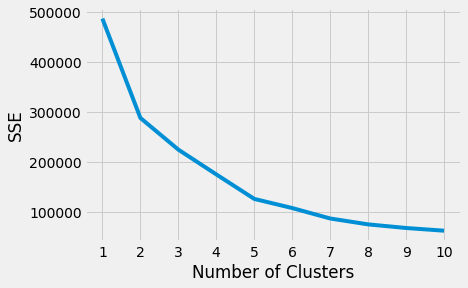

In [221]:
 plt.style.use("fivethirtyeight")
 plt.plot(range(1, 11), sse)
 plt.xticks(range(1, 11))
 plt.xlabel("Number of Clusters")
 plt.ylabel("SSE")
 plt.show()

#  In this example, the elbow is probably located at x=5:

In [222]:
## but if doubt about this inflection point, you can use kneed to programatically identify the elbox point 
from kneed import KneeLocator

kl = KneeLocator(
  
    range(1, 11), sse, curve="convex", direction="decreasing"
)
kl.elbow

5

### Find the appropriate cluster number with "The silhouette coefficient Method"
This is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors: <br>

    How close the data point is to other points in the cluster<br>
    How far away the data point is from points in other clusters<br>

Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters. 

In [223]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

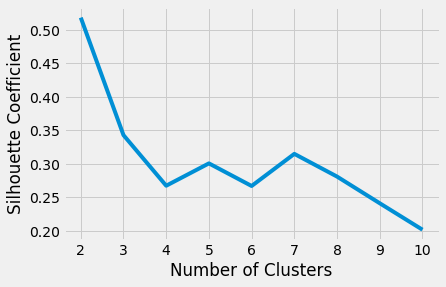

In [224]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

### Build a robust k-means clustering pipeline. 
https://realpython.com/k-means-clustering-python/